# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 
***


## Import Packages

In [10]:
#importing some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [11]:
import os
import glob
dirs = os.listdir("data/vehicles/")
cars = []
print(dirs)
for image_type in dirs:
    cars.extend(glob.glob('data/vehicles/'+ image_type+'/*.png'))
    
print('Number of Vehicles Images found', len(cars))

with open('data/vehicles/cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')


dirs = os.listdir("data/non-vehicles/")
notcars = []
print(dirs)
for image_type in dirs:
    notcars.extend(glob.glob('data/non-vehicles/'+ image_type+'/*.png'))
    
print('Number of Non-Vehicles Images found', len(notcars))

with open('data/non-vehicles/notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


['.DS_Store', 'cars.txt', 'GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
Number of Vehicles Images found 8792
['.DS_Store', 'Extras', 'GTI', 'notcars.txt']
Number of Non-Vehicles Images found 8968


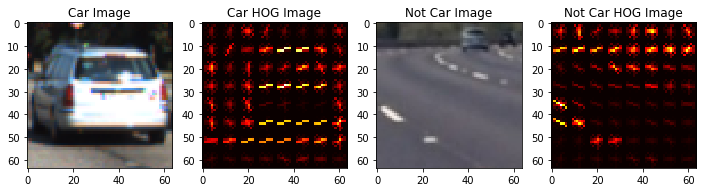

In [12]:
from vehicle_detection import Vehicle_Detection
vd = Vehicle_Detection(ystart=400,threshold_factor=10, heat_threshold=16, window=64, scales=[2.5,1.5])
# Choose random car / not-car indices
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

# Read in car / not-car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB' # #ANY OTHER
orient = 9
pix_per_call = 8
cell_per_block =2
hog_channel =0
spacial_size = (16,16)
hist_bins = 16
spacial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = vd.single_img_features_train(car_image, color_space=color_space, spatial_size=spacial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spacial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features, notcar_hog_image = vd.single_img_features_train(notcar_image, color_space=color_space, spatial_size=spacial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spacial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['Car Image', 'Car HOG Image', 'Not Car Image', 'Not Car HOG Image']
fig = plt.figure(figsize=(12,3))
vd.visualise(fig,1,4,images,titles)

In [13]:
# from vehicle_detection import Vehicle_Detection
import time
import pickle
# vd = Vehicle_Detection()

# Define feature parameters
color_space = 'YCrCb' # #ANY OTHER
orient = 9
pix_per_cell = 8
cell_per_block =2
hog_channel ='ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000

# Choose random car / not-car indices
car_indxs = np.random.randint(0,len(cars),n_samples)
notcar_indxs = np.random.randint(0,len(notcars),n_samples)

# Read in car / not-car image
test_cars = cars#np.array(cars)[car_indxs]
test_notcars = notcars#np.array(notcars)[notcar_indxs]

car_features = vd.extract_features(test_cars, color_space=color_space, spatial_size=spacial_size,
                         hist_bins=hist_bins, orient=orient,
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = vd.extract_features(test_notcars, color_space=color_space, spatial_size=spacial_size,
                         hist_bins=hist_bins, orient=orient,
                         pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(time.time()-t, ' Seconds to compute features...')
X = np.vstack((car_features, notcar_features)).astype(np.float)
# Fit a per column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, 'orientations,', pix_per_cell, 'pixels per cell', cell_per_block, 'cells per block,', hist_bins,
     'histogram bins, and', spacial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the learning time of the SVC
t=time.time()
svc.fit(X_train,y_train)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["clf"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hog_channel"] = hog_channel
dist_pickle["hist_bins"] = hist_bins
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
pickle.dump( dist_pickle, open( "model/dist_pickle.p", "wb" ) )

print(round(time.time()-t, 2), ' Seconds to train SVC...')
# Check the score of the SVC
print('Test accuracy of svc = ', round(svc.score(X_test,y_test),4))



651.5284330844879  Seconds to compute features...
Using:  9 orientations, 8 pixels per cell 2 cells per block, 16 histogram bins, and (16, 16) spatial sampling
Feature vector length: 6156
1993.78  Seconds to train SVC...
Test accuracy of svc =  0.9882


In [17]:
import time
import pickle
# vd = Vehicle_Detection()

# Define feature parameters
color_space = 'YCrCb' # #ANY OTHER
orient = 9
pix_per_cell = 8
cell_per_block =2
hog_channel ='ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

dist_pickle = pickle.load( open("model/dist_pickle.p", "rb" ) )
svc = dist_pickle["clf"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


1.1034581661224365  Seconds to run
1.0880639553070068  Seconds to run
1.083885908126831  Seconds to run
1.074826955795288  Seconds to run
1.095095157623291  Seconds to run
1.078099012374878  Seconds to run


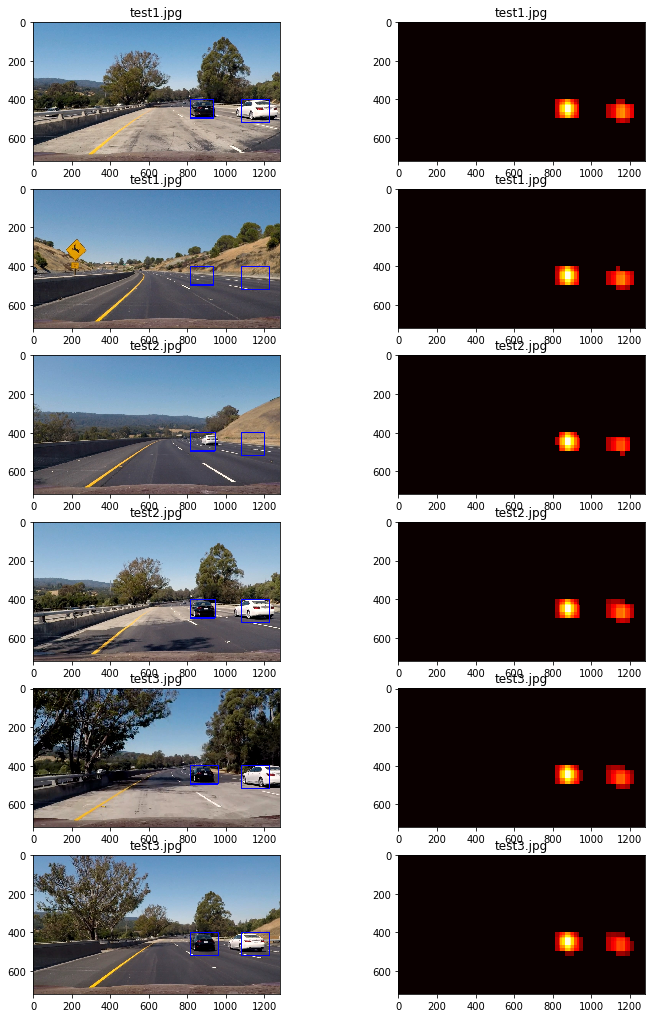

In [12]:
import os
import warnings
from scipy.ndimage.measurements import label
warnings.filterwarnings('ignore')

out_images = []
out_map = []
# out_titles =[]
out_boxes = []
#consider a narrower swath in y
ystart = 400
ystop = 656
scales = [2.5,1.5]
for img_src in image_files:
    for scale in vd.scales:
        t=time.time()
        img = mpimg.imread(img_src)
        out_img, heatmap = vd.find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        vd.heatmaps.append(heatmap)
    intergrated_heat_maps = np.sum(vd.heatmaps, axis=0)
#     threshold_heat_map = vd.apply_threshold(intergrated_heat_maps,vd.heat_threshold)
    threshold_heat_map = vd.apply_threshold(intergrated_heat_maps,10)
    labels = label(threshold_heat_map)

    draw_image = vd.draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_image)
    out_images.append(intergrated_heat_maps)
    print(time.time()-t, ' Seconds to run')
    cv2.imwrite('output_images/'+ img_src.split('/')[1], draw_img)

fig = plt.figure(figsize=(12,24))
vd.visualise(fig,8,2,out_images,out_titles)

['.DS_Store', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
0.0 1.0


/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.3630800247192383  Seconds to process one image searching 57  Windows
0.0 1.0
0.3273289203643799  Seconds to process one image searching 57  Windows
0.0 1.0
0.3070681095123291  Seconds to process one image searching 57  Windows
0.0 1.0
0.2922861576080322  Seconds to process one image searching 57  Windows
0.0 1.0
0.29375720024108887  Seconds to process one image searching 57  Windows
0.0 1.0
0.29604005813598633  Seconds to process one image searching 57  Windows


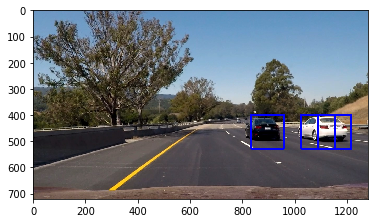

In [14]:
import os
print(dirs)
image_files = glob.glob('test_images/test*.jpg')
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop = [None, None] # Min and max in x to search in slide_window()
overlap = 0.5

for image_name in image_files:
    t1 = time.time()
    imagex = mpimg.imread(image_name)
    draw_img = np.copy(imagex)
    imagex = imagex.astype(np.float32)/255
    print(np.min(imagex), np.max(imagex))
    windows = vd.slide_window(imagex, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                     xy_window=(128, 128), xy_overlap=(overlap, overlap))
    hot_windows = vd.search_windows(imagex, windows, svc, X_scaler, color_space=color_space,
                       spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                       hist_feat=hist_feat, hog_feat=hog_feat)
    window_image = vd.draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_image)
    titles.append('')
    print(time.time()-t1, ' Seconds to process one image searching', len(windows), ' Windows')
#     result = vd.process_image(imagex)
    cv2.imwrite('output_images/'+ image_name.split('/')[1], window_image)
    plt.imshow(window_image)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
from vehicle_detection import Vehicle_Detection
# vd = Vehicle_Detection(ystart=336,threshold_factor=20, heat_threshold=14, window=64, scales=[1.1,2,2.6])
vd = Vehicle_Detection(ystart=336, threshold_factor=90, heat_threshold=45,scales=[1,1.2,2,2.5])

output_video1 = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(vd.process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output_video1, audio=False)

Using TensorFlow backend.


[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [1:37:48<00:02,  2.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 50min 54s, sys: 3min 35s, total: 54min 29s
Wall time: 1h 37min 49s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video1))